In [295]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [296]:
seed = 4
np.random.seed(seed)

In [297]:
# preprocess data
df = pd.read_csv('data/Hitters.csv')
df = df.replace('?', np.nan) # assume ? is na value
full_df = df # df without dropped values, bad stuff should only in salary
df = df.dropna()
qual = ['League', 'Division', 'NewLeague']

for q in qual:
    vals = df[q].unique()
    df.loc[:, [q]] = df[q].map({key: index for index, key in enumerate(vals)})

/tmp/ipykernel_10846/4072901791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, [q]] = df[q].map({key: index for index, key in enumerate(vals)})
/tmp/ipykernel_10846/4072901791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, [q]] = df[q].map({key: index for index, key in enumerate(vals)})
/tmp/ipykernel_10846/4072901791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [298]:
# set the variables you want to use
y = df['Salary']
x = df.drop(['Salary'], axis=1).astype('float64')

In [299]:
# train masks
train_mask = np.full(len(x), True) 
train_mask[len(x) // 2:len(x)] = False
np.random.shuffle(train_mask)
test_mask = np.logical_not(train_mask)

In [300]:
# datasets
x_train = x[train_mask] 
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]

In [349]:
# PCR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import scale
from sklearn.metrics import explained_variance_score

In [302]:
# sadge i have to implement this myself doesn't seem like there's a library online
pca = PCA() # this will compute the n x p', where p' <= p and is the new number of vars we use
x_reduced = pca.fit_transform(scale(x_train)) # scaling x, because they are of different units

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) # cross validation method, 10 splits, repeat this 1 time
reg = LinearRegression()
mse = [] # stores the list of mean squared errors

In [303]:
# scores like big stuff, so negative mse
intercept_score = -1 * model_selection.cross_val_score(
    reg,
    np.ones((len(x_reduced), 1)),
    y_train, 
    cv=cv, 
    scoring='neg_mean_squared_error').mean()

mse.append(intercept_score) # because linear regression usually appends the constant, so we gotta do this separately

for i in range(1, x_reduced.shape[1] + 1):
    score = -1 * model_selection.cross_val_score(
        reg,
        x_reduced[:, :i], # data is prescaled already, and LinearRegression does not scale it
        y_train, 
        cv=cv, 
        scoring='neg_mean_squared_error').mean()
    mse.append(score)

In [304]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [350]:
exp_var = np.array(pca.explained_variance_ratio_)
print(f'explained variance percentages:\n{exp_var.cumsum()}') 

exp_var_y = explained_variance_score(y_test, pred)
print(f'explained variance percentages: {exp_var_y}') 

explained variance percentages:
[0.38872044 0.60803432 0.71111221 0.79645065 0.84911236 0.89664366
 0.92747182 0.95026637 0.9638077  0.97367601 0.98154826 0.98804431
 0.99318913 0.99569981 0.99750513 0.99886482 0.99971492 0.99994069
 1.        ]
explained variance percentages: 0.45481752658052654


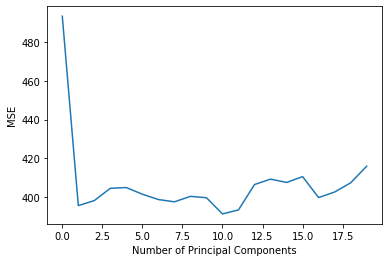

best model errors uses 10 parameters and achieves error 391.2562615640673


In [306]:
errors = np.array(mse) 
errors = np.sqrt(errors)
plt.plot(errors)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.show()
print(f'best model errors uses {errors.argmin()} parameters and achieves error {errors.min()}') # 18 predictors is best 
# but this stuff is so jank with how much the random seed changes it :/

In [307]:
# let's try with less parameters and see mse we achieve
parameters = 7
x_reduced_test = pca.transform(scale(x_test))[:, :parameters]

# train PCR model on training data 
reg = LinearRegression()
reg.fit(x_reduced[:, :parameters], y_train) # 7 parameters

# calculate RMSE
pred = reg.predict(x_reduced_test)
error = np.sqrt(mean_squared_error(y_test, pred))
print(f'test error: {error}')


test error: 319.2450447218978


In [308]:
# now for pls regression
from sklearn.cross_decomposition import PLSRegression

In [309]:
import warnings
warnings.filterwarnings('default')

In [339]:
mse = []
mse.append(intercept_score) # idk why, but PLS doesn't work with only intercept

for i in np.arange(1, 20): # 19 components in PCA, so this makes sense
    pls = PLSRegression(n_components=i)
    score = -1 * model_selection.cross_val_score(
        pls, 
        x_train, 
        y_train, 
        cv=cv,
        scoring='neg_mean_squared_error').mean()
    mse.append(score)

best model errors uses 1 parameters and achieves error 395.1075480384927


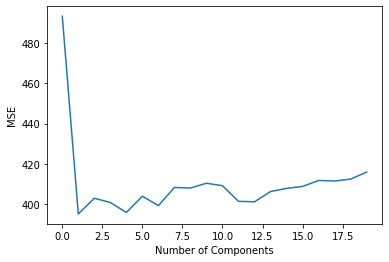

In [340]:
errors = np.sqrt(np.array(mse))
plt.plot(errors)
plt.xlabel('Number of Components')
plt.ylabel('MSE')
print(f'best model errors uses {errors.argmin()} parameters and achieves error {errors.min()}') # 18 predictors is best

In [341]:
pls = PLSRegression(n_components=2) # scale is true
pls.fit(x_train, y_train) # we don't need to do anything to the data before hand
residuals = y_test - pls.predict(x_test).reshape((-1,)) # the same scaling is applied to x_test
error = np.sqrt(np.square(residuals).mean())
print(f'test error {error}')

test error 312.56846591998453


In [348]:
exp_var = explained_variance_score(y_test, pls.predict(x_test).reshape((-1,)))
print(f'variance explained: {exp_var}') # explains more variance than PCR, because that's what PLS targets, it includes y in var calculations

variance explained: 0.46270659803370184
